In [1]:
!pip install torch transformers

In [2]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer

# TokenPooling class
class TokenPooling(nn.Module):
    def __init__(self, pool_factor=2):
        super(TokenPooling, self).__init__()
        self.pool_factor = pool_factor

    def forward(self, x):
        print(f"Before TokenPooling: {x.shape}")
        batch_size, seq_len, embed_dim = x.size()
        pooled_seq_len = seq_len // self.pool_factor
        x = x[:, :pooled_seq_len * self.pool_factor, :]
        x = x.view(batch_size, pooled_seq_len, self.pool_factor, embed_dim)
        x = x.mean(dim=2)
        print(f"After TokenPooling: {x.shape}")
        return x

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        print(f"Before PositionalEncoding: {x.shape}")
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        print(f"After PositionalEncoding: {x.shape}")
        return x

# EAM Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        print(f"After Embedding: {x.shape}")
        x = x.transpose(0, 1)  # Shape: (seq_len, batch_size, embed_dim)
        print(f"After Transpose 1: {x.shape}")
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # Shape: (batch_size, seq_len, embed_dim)
        print(f"After Transpose 2: {x.shape}")
        x = self.token_pooling(x)  # Shape: (batch_size, pooled_seq_len, embed_dim)
        x = self.fc_out(x.mean(dim=1))  # Shape: (batch_size, num_classes)
        print(f"Output shape: {x.shape}")
        return x

# Initialize the model and dummy input
vocab_size = 30522  # Example vocab size (BERT base uncased tokenizer)
embed_dim = 16  # Embedding dimension
num_heads = 2  # Number of attention heads (not used in this simplified example)
num_classes = 10  # Example number of output classes
pool_factor = 2  # Pooling factor to reduce sequence length

model = EAMIntentClassifier(vocab_size, embed_dim, num_heads, num_classes, pool_factor)

# Dummy input (batch_size=32, seq_len=64)
input_ids = torch.randint(0, vocab_size, (32, 64))

# Forward pass to print shapes
model(input_ids)


Input shape: torch.Size([32, 64])
After Embedding: torch.Size([32, 64, 16])
After Transpose 1: torch.Size([64, 32, 16])
Before PositionalEncoding: torch.Size([64, 32, 16])
After PositionalEncoding: torch.Size([64, 32, 16])
After Transpose 2: torch.Size([32, 64, 16])
Before TokenPooling: torch.Size([32, 64, 16])
After TokenPooling: torch.Size([32, 32, 16])
Output shape: torch.Size([32, 10])


tensor([[-0.0308,  0.3620, -0.5677,  0.0658,  0.1260, -0.3078, -0.2964, -0.5298,
         -0.5907, -0.1225],
        [-0.0056,  0.2767, -0.4624,  0.0692,  0.1315, -0.1131, -0.3282, -0.5048,
         -0.5294, -0.0899],
        [ 0.0433,  0.4177, -0.5005, -0.0071,  0.1198, -0.0797, -0.3412, -0.5080,
         -0.4810, -0.1296],
        [ 0.0361,  0.3689, -0.5719,  0.0749,  0.0878, -0.2333, -0.2306, -0.4639,
         -0.5301, -0.0522],
        [-0.0519,  0.3332, -0.5480,  0.0454,  0.0815, -0.1937, -0.3619, -0.6144,
         -0.5566, -0.1486],
        [ 0.0223,  0.3030, -0.5880,  0.0162,  0.1603, -0.2674, -0.3556, -0.5642,
         -0.5478, -0.1400],
        [-0.0991,  0.3221, -0.5072,  0.0810,  0.1981, -0.2308, -0.3930, -0.5727,
         -0.5958, -0.0365],
        [ 0.0205,  0.2326, -0.4603, -0.0467,  0.2450, -0.1911, -0.3351, -0.5067,
         -0.4814, -0.1196],
        [ 0.0210,  0.2712, -0.5833,  0.0435,  0.0942, -0.1795, -0.2843, -0.5152,
         -0.5333, -0.1311],
        [-0.0617,  

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import time

# TokenPooling class
class TokenPooling(nn.Module):
    def __init__(self, pool_factor=2):
        super(TokenPooling, self).__init__()
        self.pool_factor = pool_factor

    def forward(self, x):
        print(f"Before Tokeinpolling{x.shape}")
        batch_size, seq_len, embed_dim = x.size()
        pooled_seq_len = seq_len // self.pool_factor
        x = x[:, :pooled_seq_len * self.pool_factor, :]
        x = x.view(batch_size, pooled_seq_len, self.pool_factor, embed_dim)
        x = x.mean(dim=2)
        print(f"Aftre Tokenpolling{x.shape}")
        return x

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        print(f"Before Positional Encoding{x.shape}")
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        print(f"After Positional Encoding{x.shape}")
        return x

# EAM Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x, attention_mask=None):
        print(f"Inpur Shape{x.shape}")
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        print(f"After Embedding{x.shape}")
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim)
        print(f"After transpose1 {x.shape}")
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        print(f"After Transpose 2:{x.shape}")
        x = self.token_pooling(x)
        x = self.fc_out(x.mean(dim=1))  # Global average pooling
        print(f"output Shpae{x.shape}")
        return x
vocab_size = 30522  # Example vocab size (BERT base uncased tokenizer)
embed_dim = 16  # Embedding dimension
num_heads = 2  # Number of attention heads (not used in this simplified example)
num_classes = 10  # Example number of output classes
pool_factor = 2  # Pooling factor to reduce sequence length

model = EAMIntentClassifier(vocab_size, embed_dim, num_heads, num_classes, pool_factor)

# Dummy input (batch_size=32, seq_len=64)
input_ids = torch.randint(0, vocab_size, (32, 64))

# Forward pass to print shapes
model(input_ids)
# Dataset preparation
# class IntentDataset(Dataset):
#     def __init__(self, df, tokenizer, max_len):
#         self.df = df
#         self.texts = df['Description'].values
#         self.labels = df['Category'].values
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]

#         # Tokenization
#         encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

#         return {
#             'input_ids': encoding['input_ids'].squeeze(),
#             'attention_mask': encoding['attention_mask'].squeeze(),
#             'label': torch.tensor(label, dtype=torch.long)
#         }

# # Load data from CSV
# train_df = pd.read_csv("/content/train.csv")
# valid_df = pd.read_csv("/content/vald.csv")
# test_df = pd.read_csv("/content/test.csv")

# # Create a mapping from text labels to numerical labels
# label_mapping = {label: idx for idx, label in enumerate(train_df['Category'].unique())}

# # Apply the mapping to all datasets
# train_df['Category'] = train_df['Category'].map(label_mapping)
# valid_df['Category'] = valid_df['Category'].map(label_mapping)
# test_df['Category'] = test_df['Category'].map(label_mapping)

# # Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# # Create dataset and DataLoader
# max_len = 64
# train_dataset = IntentDataset(train_df, tokenizer, max_len)
# valid_dataset = IntentDataset(valid_df, tokenizer, max_len)
# test_dataset = IntentDataset(test_df, tokenizer, max_len)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=32)
# test_loader = DataLoader(test_dataset, batch_size=32)

# # Training function
# def train_model(model, dataloader, criterion, optimizer, epochs, device):
#     model.to(device)
#     train_losses = []
#     all_accuracies = []

#     for epoch in range(epochs):
#         model.train()
#         total_loss = 0
#         correct_predictions = 0
#         total_samples = 0

#         for batch in dataloader:
#             texts_batch, labels_batch = batch['input_ids'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()

#             outputs = model(texts_batch)
#             loss = criterion(outputs, labels_batch)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct_predictions += (predicted == labels_batch).sum().item()
#             total_samples += labels_batch.size(0)

#         avg_loss = total_loss / len(dataloader)
#         accuracy = correct_predictions / total_samples

#         train_losses.append(avg_loss)
#         all_accuracies.append(accuracy)

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

#     return train_losses, all_accuracies

# # Initialize the model
# vocab_size = tokenizer.vocab_size
# embed_dim = 16
# num_heads = 2
# num_classes = len(train_df['Category'].unique())

# eam_model = EAMIntentClassifier(vocab_size=vocab_size, embed_dim=embed_dim, num_heads=num_heads, num_classes=num_classes, pool_factor=2)
# optimizer_eam = optim.Adam(eam_model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Train the EAM model
# print("Training EAM Intent Classifier")
# eam_losses, eam_accuracies = train_model(eam_model, train_loader, criterion, optimizer_eam, epochs=50, device=device)

# # Plot Loss and Accuracy
# plt.figure(figsize=(12, 6))

# # Plot Loss over Epochs
# plt.subplot(1, 2, 1)
# plt.plot(eam_losses, label="EAM Model Loss", color="blue")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("EAM Model Training Loss")
# plt.legend()

# # Plot Accuracy over Epochs
# plt.subplot(1, 2, 2)
# plt.plot(eam_accuracies, label="EAM Model Accuracy", color="blue")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("EAM Model Training Accuracy")
# plt.legend()

# plt.tight_layout()
# plt.show()


Inpur Shapetorch.Size([32, 64])
After Embeddingtorch.Size([32, 64, 16])
After transpose1 torch.Size([64, 32, 16])
Before Positional Encodingtorch.Size([64, 32, 16])
After Positional Encodingtorch.Size([64, 32, 16])
After Transpose 2:torch.Size([32, 64, 16])
Before Tokeinpollingtorch.Size([32, 64, 16])
Aftre Tokenpollingtorch.Size([32, 32, 16])
output Shpaetorch.Size([32, 10])


tensor([[ 5.9405e-01, -5.2843e-01,  7.4323e-01, -3.0807e-02,  6.1377e-01,
          1.1670e-01,  5.0202e-01, -4.9063e-01, -5.5672e-01,  1.2829e-01],
        [ 6.5456e-01, -5.8484e-01,  6.7955e-01, -2.4207e-02,  6.7721e-01,
          1.0781e-01,  3.5846e-01, -4.9446e-01, -4.6766e-01,  7.9521e-02],
        [ 5.8725e-01, -5.3651e-01,  7.3972e-01,  6.1461e-02,  5.5163e-01,
          9.9671e-03,  3.4861e-01, -4.3795e-01, -4.7500e-01,  3.0140e-02],
        [ 5.4819e-01, -5.4860e-01,  7.4956e-01, -4.0874e-04,  5.7992e-01,
          2.5406e-02,  3.7537e-01, -4.5023e-01, -5.0864e-01,  3.5782e-02],
        [ 3.7470e-01, -5.8525e-01,  7.8003e-01,  1.4120e-02,  5.3673e-01,
          1.4828e-01,  2.6990e-01, -4.8354e-01, -5.2035e-01,  1.2353e-02],
        [ 4.7485e-01, -5.7607e-01,  6.3301e-01, -5.5947e-02,  6.0343e-01,
          1.0189e-01,  3.2216e-01, -3.7127e-01, -5.8225e-01,  1.4580e-02],
        [ 5.3855e-01, -4.3214e-01,  6.3155e-01,  2.1290e-02,  5.3501e-01,
          3.0532e-01,  3.8495e-0

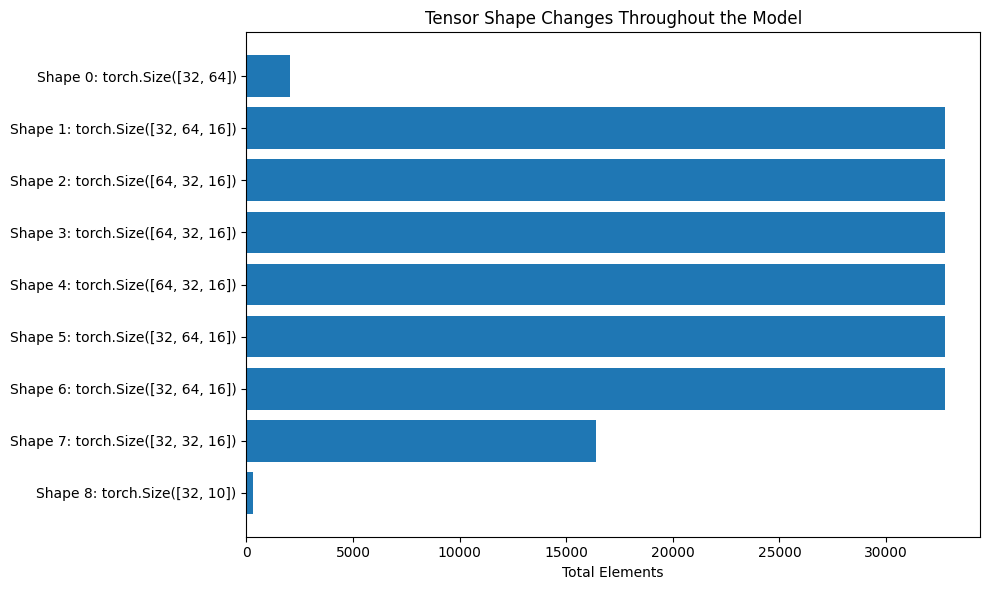

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# TokenPooling class
class TokenPooling(nn.Module):
    def __init__(self, pool_factor=2):
        super(TokenPooling, self).__init__()
        self.pool_factor = pool_factor

    def forward(self, x):
        shapes.append(x.shape)  # Add shape before pooling
        batch_size, seq_len, embed_dim = x.size()
        pooled_seq_len = seq_len // self.pool_factor
        x = x[:, :pooled_seq_len * self.pool_factor, :]
        x = x.view(batch_size, pooled_seq_len, self.pool_factor, embed_dim)
        x = x.mean(dim=2)
        shapes.append(x.shape)  # Add shape after pooling
        return x

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        shapes.append(x.shape)  # Add shape before positional encoding
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        shapes.append(x.shape)  # Add shape after positional encoding
        return x

# EAM Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        shapes.append(x.shape)  # Add initial input shape
        x = self.embedding(x)
        shapes.append(x.shape)  # After embedding
        x = x.transpose(0, 1)
        shapes.append(x.shape)  # After first transpose
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)
        shapes.append(x.shape)  # After second transpose
        x = self.token_pooling(x)
        x = self.fc_out(x.mean(dim=1))
        shapes.append(x.shape)  # Final output shape
        return x

# Function to plot the tensor shapes
def plot_shapes(shapes):
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = range(len(shapes))
    labels = [f"Shape {i}: {shape}" for i, shape in enumerate(shapes)]

    ax.barh(y_pos, [s.numel() for s in shapes], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # Invert to match the order of operations
    ax.set_xlabel('Total Elements')
    ax.set_title('Tensor Shape Changes Throughout the Model')

    plt.tight_layout()
    plt.show()

# Initialize the model and dummy input
vocab_size = 30522  # Example vocab size (BERT base uncased tokenizer)
embed_dim = 16  # Embedding dimension
num_heads = 2  # Number of attention heads (not used in this simplified example)
num_classes = 10  # Example number of output classes
pool_factor = 2  # Pooling factor to reduce sequence length

model = EAMIntentClassifier(vocab_size, embed_dim, num_heads, num_classes, pool_factor)

# Dummy input (batch_size=32, seq_len=64)
input_ids = torch.randint(0, vocab_size, (32, 64))

# Track shapes at each layer
shapes = []

# Forward pass to capture shapes
model(input_ids)

# Plot the shape changes
plot_shapes(shapes)


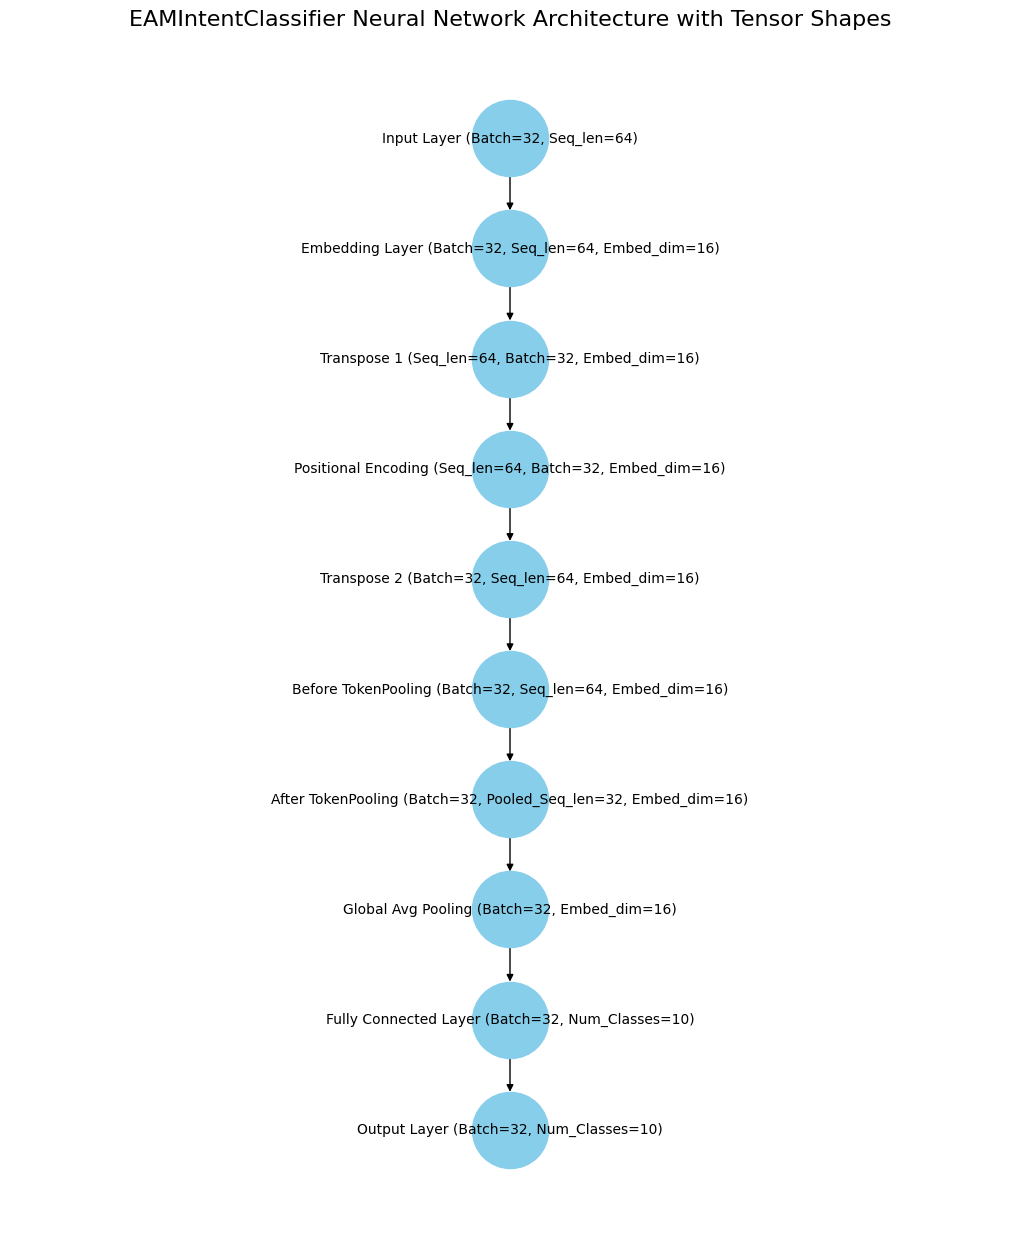

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_neural_network_with_shapes():
    # Create a directed graph
    G = nx.DiGraph()

    # Layers and their shapes based on the provided tensor sizes
    layers = [
        "Input Layer (Batch=32, Seq_len=64)",
        "Embedding Layer (Batch=32, Seq_len=64, Embed_dim=16)",
        "Transpose 1 (Seq_len=64, Batch=32, Embed_dim=16)",
        "Positional Encoding (Seq_len=64, Batch=32, Embed_dim=16)",
        "Transpose 2 (Batch=32, Seq_len=64, Embed_dim=16)",
        "Before TokenPooling (Batch=32, Seq_len=64, Embed_dim=16)",
        "After TokenPooling (Batch=32, Pooled_Seq_len=32, Embed_dim=16)",
        "Global Avg Pooling (Batch=32, Embed_dim=16)",
        "Fully Connected Layer (Batch=32, Num_Classes=10)",
        "Output Layer (Batch=32, Num_Classes=10)"
    ]

    # Add nodes for each layer
    for i, layer in enumerate(layers):
        G.add_node(i, label=layer)

    # Add edges (connections between layers)
    edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)]
    G.add_edges_from(edges)

    # Define positions of nodes
    pos = {
        0: (0, 9),
        1: (0, 8),
        2: (0, 7),
        3: (0, 6),
        4: (0, 5),
        5: (0, 4),
        6: (0, 3),
        7: (0, 2),
        8: (0, 1),
        9: (0, 0)
    }

    # Plot the graph
    plt.figure(figsize=(10, 12))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color="skyblue", arrows=True)

    # Add labels manually
    labels = {i: layers[i] for i in range(len(layers))}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    # Show the plot
    plt.title("EAMIntentClassifier Neural Network Architecture with Tensor Shapes", fontsize=16)
    plt.show()

# Plot the neural network architecture with tensor shapes
plot_neural_network_with_shapes()


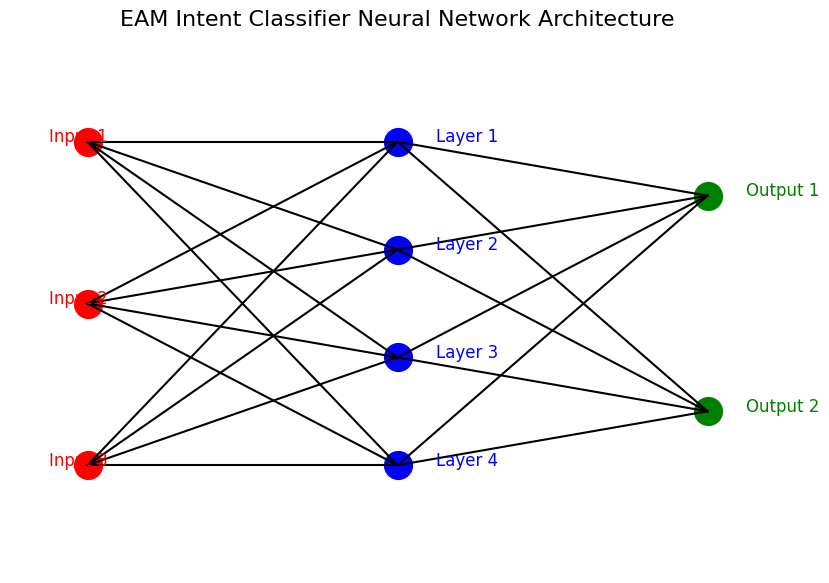

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to draw neural network
def draw_eam_architecture():
    fig, ax = plt.subplots(figsize=(10, 7))

    # Define positions of the layers
    input_layer_y = np.linspace(0.8, 0.2, 3)  # 3 nodes in the input layer
    hidden_layer_y = np.linspace(0.8, 0.2, 4)  # 4 nodes in the hidden layer (for EAM-like layers)
    output_layer_y = np.linspace(0.7, 0.3, 2)  # 2 nodes in the output layer (final classification)

    # X coordinates for the layers
    input_layer_x = [0.1] * len(input_layer_y)
    hidden_layer_x = [0.5] * len(hidden_layer_y)
    output_layer_x = [0.9] * len(output_layer_y)

    # Plot input layer nodes
    for i in range(len(input_layer_y)):
        ax.plot(input_layer_x[i], input_layer_y[i], 'ro', markersize=20)
        ax.text(input_layer_x[i] - 0.05, input_layer_y[i], f'Input {i+1}', fontsize=12, color='red')

    # Plot hidden layer nodes (EAM architecture components)
    for i in range(len(hidden_layer_y)):
        ax.plot(hidden_layer_x[i], hidden_layer_y[i], 'bo', markersize=20)
        ax.text(hidden_layer_x[i] + 0.05, hidden_layer_y[i], f'Layer {i+1}', fontsize=12, color='blue')

    # Plot output layer nodes
    for i in range(len(output_layer_y)):
        ax.plot(output_layer_x[i], output_layer_y[i], 'go', markersize=20)
        ax.text(output_layer_x[i] + 0.05, output_layer_y[i], f'Output {i+1}', fontsize=12, color='green')

    # Connect input layer to hidden layer
    for i in range(len(input_layer_y)):
        for j in range(len(hidden_layer_y)):
            ax.plot([input_layer_x[i], hidden_layer_x[j]], [input_layer_y[i], hidden_layer_y[j]], 'k-')

    # Connect hidden layer to output layer
    for i in range(len(hidden_layer_y)):
        for j in range(len(output_layer_y)):
            ax.plot([hidden_layer_x[i], output_layer_x[j]], [hidden_layer_y[i], output_layer_y[j]], 'k-')

    # Set plot limits and hide axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    plt.title('EAM Intent Classifier Neural Network Architecture', fontsize=16)
    plt.show()

# Call the function to draw the neural network architecture
draw_eam_architecture()


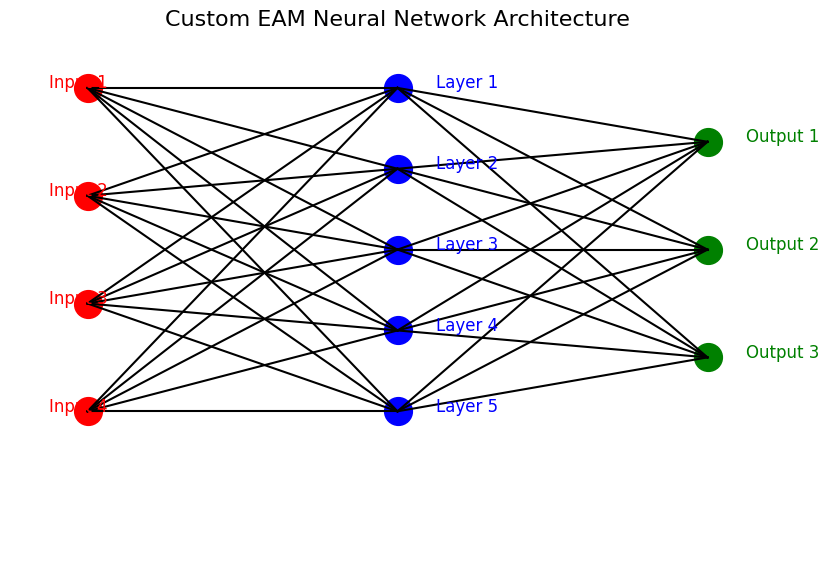

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def draw_custom_neural_network():
    fig, ax = plt.subplots(figsize=(10, 7))

    # Define positions of the layers
    input_layer_y = np.linspace(0.9, 0.3, 4)  # 4 input nodes
    hidden_layer_y = np.linspace(0.9, 0.3, 5)  # 5 nodes in hidden layer (e.g., token pooling, embedding, etc.)
    output_layer_y = np.linspace(0.8, 0.4, 3)  # 3 nodes in the output layer

    # X coordinates for the layers
    input_layer_x = [0.1] * len(input_layer_y)
    hidden_layer_x = [0.5] * len(hidden_layer_y)
    output_layer_x = [0.9] * len(output_layer_y)

    # Plot input layer nodes
    for i in range(len(input_layer_y)):
        ax.plot(input_layer_x[i], input_layer_y[i], 'ro', markersize=20)
        ax.text(input_layer_x[i] - 0.05, input_layer_y[i], f'Input {i+1}', fontsize=12, color='red')

    # Plot hidden layer nodes (e.g., EAM architecture components)
    for i in range(len(hidden_layer_y)):
        ax.plot(hidden_layer_x[i], hidden_layer_y[i], 'bo', markersize=20)
        ax.text(hidden_layer_x[i] + 0.05, hidden_layer_y[i], f'Layer {i+1}', fontsize=12, color='blue')

    # Plot output layer nodes
    for i in range(len(output_layer_y)):
        ax.plot(output_layer_x[i], output_layer_y[i], 'go', markersize=20)
        ax.text(output_layer_x[i] + 0.05, output_layer_y[i], f'Output {i+1}', fontsize=12, color='green')

    # Connect input layer to hidden layer
    for i in range(len(input_layer_y)):
        for j in range(len(hidden_layer_y)):
            ax.plot([input_layer_x[i], hidden_layer_x[j]], [input_layer_y[i], hidden_layer_y[j]], 'k-')

    # Connect hidden layer to output layer
    for i in range(len(hidden_layer_y)):
        for j in range(len(output_layer_y)):
            ax.plot([hidden_layer_x[i], output_layer_x[j]], [hidden_layer_y[i], output_layer_y[j]], 'k-')

    # Set plot limits and hide axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    plt.title('Custom EAM Neural Network Architecture', fontsize=16)
    plt.show()

# Draw the neural network architecture
draw_custom_neural_network()
